In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hadicanmunis","key":"b44a2eb3779ffb94c073015c60c0ad77"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d hadicanmunis/plantvillage-dataset

 99% 359M/363M [00:14<00:00, 38.2MB/s]
100% 363M/363M [00:14<00:00, 26.8MB/s]


In [4]:
!unzip -qq plantvillage-dataset.zip

In [5]:
import os, shutil, pathlib
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
import matplotlib.pyplot as plt

In [6]:
dataset_dir = pathlib.Path("/content/Plant_leave_diseases_dataset")

In [7]:
lst = os.listdir(dataset_dir)
lst.sort()
lst

['Pepper_Bell_Bacterial_Spot',
 'Pepper_Bell_Healthy',
 'Potato_Early_Blight',
 'Potato_Healthy',
 'Potato_Late_Blight',
 'Tomato_Bacterial_Spot',
 'Tomato_Early_Blight',
 'Tomato_Healthy',
 'Tomato_Late_Blight',
 'Tomato_Leaf_Mold',
 'Tomato_Mosaic_Virus',
 'Tomato_Septoria_Leaf_Spot',
 'Tomato_Target_Spot',
 'Tomato_Two-spotted_Spider_Mite',
 'Tomato_Yellow_Leaf_Curl_Virus']

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds, val_ds = image_dataset_from_directory(
    dataset_dir,
    label_mode="categorical",
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="both",
)

Found 19136 files belonging to 15 classes.
Using 13396 files for training.
Using 5740 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Pepper_Bell_Bacterial_Spot', 'Pepper_Bell_Healthy', 'Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight', 'Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Healthy', 'Tomato_Late_Blight', 'Tomato_Leaf_Mold', 'Tomato_Mosaic_Virus', 'Tomato_Septoria_Leaf_Spot', 'Tomato_Target_Spot', 'Tomato_Two-spotted_Spider_Mite', 'Tomato_Yellow_Leaf_Curl_Virus']


In [10]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
    break

(64, 224, 224, 3)
(64, 15)


In [11]:
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
    break

(64, 224, 224, 3)
(64, 15)


In [12]:
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=210>

In [13]:
tf.data.experimental.cardinality(val_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=90>

In [14]:
test_ds = val_ds.take(45)
val_ds = val_ds.skip(45)

In [15]:
tf.data.experimental.cardinality(val_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=45>

In [16]:
tf.data.experimental.cardinality(test_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=45>

In [17]:
conv_base = keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))

conv_base.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [18]:
conv_base.trainable = True
for layer in conv_base.layers[:-15]:
    layer.trainable = False

In [19]:
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

In [21]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.4),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.1)
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                           

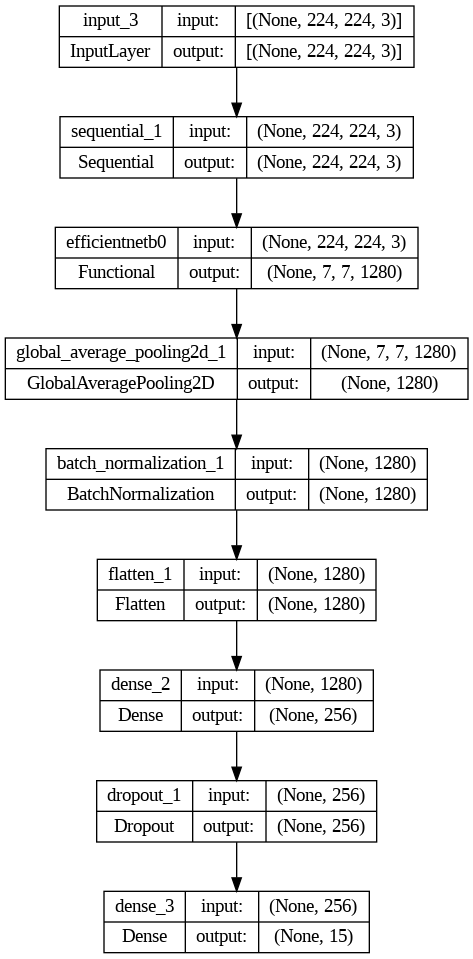

In [23]:
keras.utils.plot_model(model, show_shapes=True)

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model_efficientnet_finetuned.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=150,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/150
210/210 [==============================] - 34s 96ms/step - loss: 3.9983 - accuracy: 0.1378 - val_loss: 2.1170 - val_accuracy: 0.3409
Epoch 2/150
210/210 [==============================] - 17s 80ms/step - loss: 2.6791 - accuracy: 0.3099 - val_loss: 1.6122 - val_accuracy: 0.4962
Epoch 3/150
210/210 [==============================] - 17s 79ms/step - loss: 2.1393 - accuracy: 0.4286 - val_loss: 1.3391 - val_accuracy: 0.5913
Epoch 4/150
210/210 [==============================] - 17s 81ms/step - loss: 1.7659 - accuracy: 0.5133 - val_loss: 1.1776 - val_accuracy: 0.6385
Epoch 5/150
210/210 [==============================] - 17s 80ms/step - loss: 1.5536 - accuracy: 0.5590 - val_loss: 1.0563 - val_accuracy: 0.6766
Epoch 6/150
210/210 [==============================] - 17s 81ms/step - loss: 1.3811 - accuracy: 0.6070 - val_loss: 0.9589 - val_accuracy: 0.7171
Epoch 7/150
210/210 [==============================] - 17s 80ms/step - loss: 1.2587 - accuracy: 0.6347 - val_loss: 0.8940 - val_ac

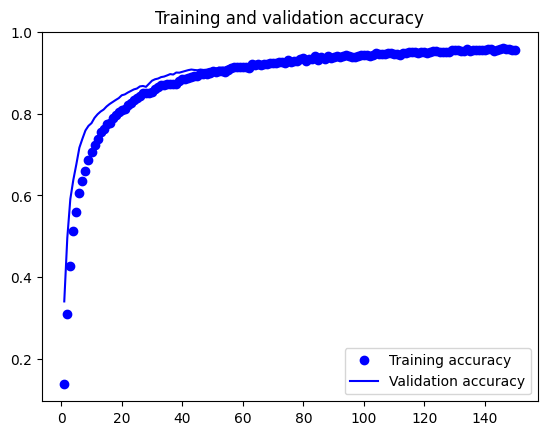

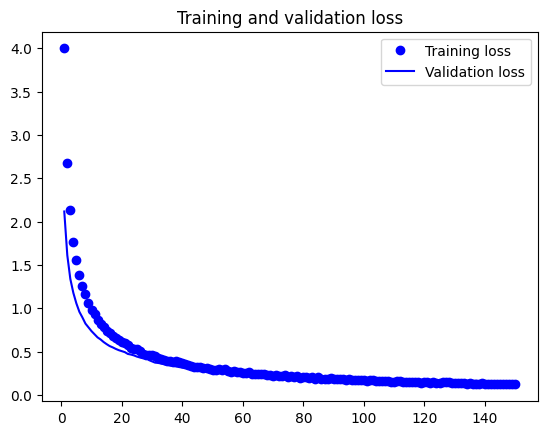

In [25]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
test_model = keras.models.load_model("model_efficientnet_finetuned.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

45/45 [==============================] - 5s 50ms/step - loss: 0.1237 - accuracy: 0.9628
Test accuracy: 0.963


In [27]:
y_pred = test_model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)

45/45 [==============================] - 3s 47ms/step


In [28]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
y_true = np.argmax(true_categories, axis=1)

In [29]:
y_true.tolist()

[8,
 11,
 11,
 8,
 14,
 13,
 12,
 14,
 5,
 12,
 5,
 2,
 4,
 13,
 13,
 13,
 6,
 0,
 14,
 7,
 5,
 4,
 12,
 7,
 9,
 1,
 4,
 8,
 12,
 9,
 8,
 13,
 8,
 1,
 11,
 2,
 14,
 7,
 7,
 6,
 6,
 13,
 11,
 4,
 0,
 2,
 10,
 1,
 6,
 11,
 5,
 8,
 14,
 12,
 5,
 1,
 4,
 6,
 7,
 13,
 11,
 5,
 7,
 13,
 8,
 4,
 12,
 14,
 14,
 11,
 5,
 14,
 11,
 13,
 11,
 4,
 6,
 11,
 7,
 8,
 2,
 4,
 5,
 1,
 4,
 6,
 9,
 8,
 0,
 8,
 7,
 5,
 9,
 13,
 14,
 4,
 1,
 5,
 10,
 4,
 7,
 6,
 1,
 0,
 13,
 5,
 1,
 5,
 6,
 12,
 6,
 0,
 13,
 12,
 7,
 0,
 4,
 14,
 7,
 14,
 14,
 5,
 14,
 1,
 9,
 6,
 6,
 7,
 8,
 14,
 4,
 13,
 9,
 5,
 11,
 9,
 13,
 5,
 8,
 4,
 7,
 7,
 0,
 13,
 13,
 10,
 10,
 8,
 7,
 2,
 4,
 12,
 11,
 6,
 13,
 14,
 5,
 5,
 11,
 4,
 8,
 5,
 12,
 4,
 8,
 7,
 8,
 2,
 4,
 12,
 0,
 11,
 1,
 14,
 7,
 6,
 5,
 12,
 8,
 14,
 11,
 9,
 10,
 14,
 4,
 12,
 5,
 5,
 4,
 12,
 8,
 7,
 10,
 14,
 4,
 12,
 5,
 13,
 9,
 5,
 8,
 10,
 13,
 11,
 12,
 6,
 4,
 7,
 11,
 13,
 1,
 11,
 1,
 7,
 8,
 1,
 11,
 7,
 5,
 11,
 0,
 7,
 14,
 14,
 4,
 12,
 1,
 11,
 1

In [30]:
predicted_labels.tolist()

[8,
 11,
 11,
 8,
 13,
 13,
 12,
 14,
 5,
 12,
 5,
 2,
 4,
 13,
 13,
 13,
 6,
 0,
 14,
 7,
 5,
 4,
 12,
 7,
 9,
 1,
 4,
 8,
 12,
 9,
 8,
 13,
 8,
 1,
 11,
 2,
 14,
 7,
 7,
 6,
 11,
 13,
 11,
 4,
 0,
 2,
 10,
 1,
 6,
 11,
 5,
 8,
 14,
 12,
 5,
 1,
 4,
 6,
 7,
 13,
 11,
 5,
 7,
 13,
 8,
 4,
 12,
 14,
 14,
 11,
 5,
 14,
 11,
 13,
 0,
 3,
 6,
 11,
 7,
 8,
 2,
 4,
 5,
 1,
 4,
 4,
 9,
 8,
 0,
 8,
 7,
 5,
 9,
 13,
 14,
 4,
 1,
 5,
 10,
 4,
 7,
 6,
 1,
 0,
 13,
 5,
 1,
 5,
 6,
 12,
 6,
 0,
 13,
 12,
 7,
 0,
 4,
 14,
 7,
 14,
 14,
 5,
 14,
 1,
 9,
 6,
 4,
 7,
 8,
 14,
 4,
 13,
 9,
 5,
 11,
 9,
 13,
 5,
 8,
 4,
 7,
 7,
 0,
 13,
 13,
 10,
 10,
 8,
 7,
 2,
 4,
 12,
 11,
 11,
 13,
 14,
 5,
 5,
 11,
 4,
 8,
 5,
 12,
 4,
 8,
 7,
 8,
 2,
 4,
 12,
 0,
 11,
 1,
 14,
 7,
 6,
 5,
 12,
 8,
 14,
 11,
 9,
 10,
 14,
 4,
 12,
 12,
 5,
 4,
 12,
 8,
 7,
 10,
 14,
 4,
 12,
 5,
 13,
 9,
 5,
 8,
 10,
 13,
 11,
 12,
 6,
 4,
 7,
 11,
 12,
 1,
 11,
 1,
 7,
 8,
 1,
 11,
 7,
 5,
 11,
 0,
 7,
 14,
 14,
 4,
 12,
 1,
 11,


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, predicted_labels)

In [32]:
print(classification_report(y_true, predicted_labels, target_names = class_names))

                                precision    recall  f1-score   support

    Pepper_Bell_Bacterial_Spot       0.98      0.99      0.98       149
           Pepper_Bell_Healthy       0.99      1.00      0.99       220
           Potato_Early_Blight       0.98      0.99      0.99       154
                Potato_Healthy       0.96      0.96      0.96        23
            Potato_Late_Blight       0.96      0.99      0.97       175
         Tomato_Bacterial_Spot       0.98      0.93      0.96       307
           Tomato_Early_Blight       0.98      0.83      0.90       144
                Tomato_Healthy       0.97      1.00      0.99       222
            Tomato_Late_Blight       0.95      0.98      0.96       281
              Tomato_Leaf_Mold       1.00      0.92      0.96       148
           Tomato_Mosaic_Virus       1.00      0.98      0.99        51
     Tomato_Septoria_Leaf_Spot       0.96      0.97      0.96       287
            Tomato_Target_Spot       0.87      0.95      0.91  

<Axes: >

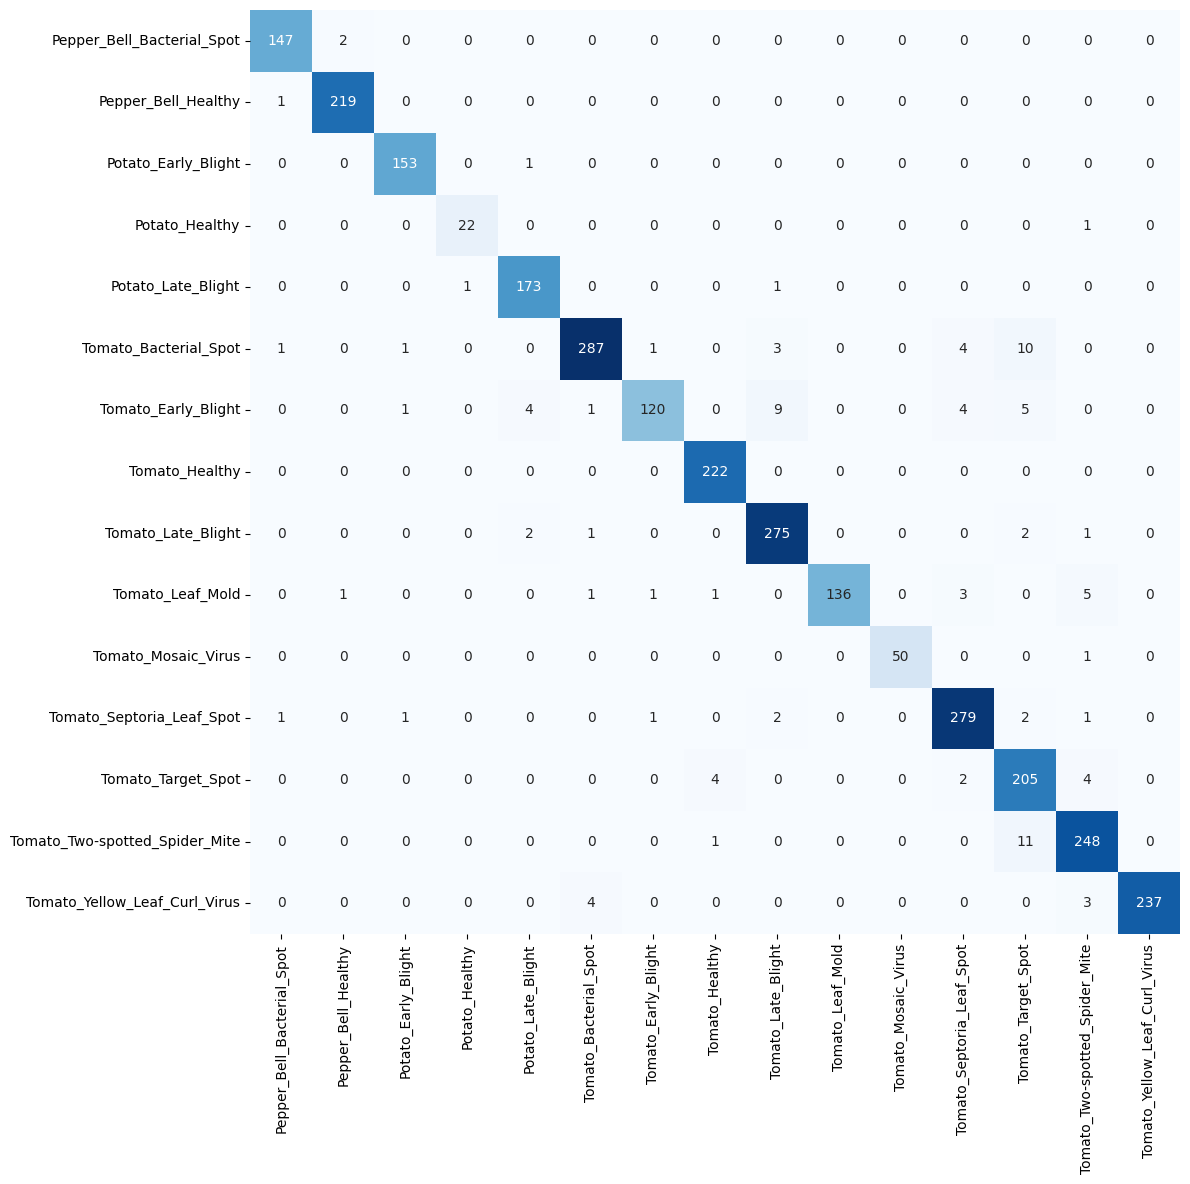

In [33]:
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)

In [63]:
image_path = "/content/Tomato-Leaf-Curl.jpg"

img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = test_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to Tomato_Yellow_Leaf_Curl_Virus with a 15.76 percent confidence.


In [64]:
score

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0.0600244 , 0.06154558, 0.06004701, 0.06002367, 0.0600196 ,
       0.06017585, 0.06003063, 0.06006498, 0.06002034, 0.06006549,
       0.0602268 , 0.06002194, 0.06001956, 0.06006704, 0.1576471 ],
      dtype=float32)>

In [65]:
image_path = "/content/Tomato-Leaf-Curl.jpg"

img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img=np.expand_dims(img, axis=0)
print ('image shape after expanding dimensions is ',img.shape)
pred=test_model.predict(img)
print (' the shape of prediction is ', pred.shape)
index=np.argmax(pred[0])
klass=class_names[index]
probability=pred[0][index]*100
print('the image is predicted as being ', klass, ' with a probability of', probability)

image shape after expanding dimensions is  (1, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
 the shape of prediction is  (1, 15)
the image is predicted as being  Tomato_Yellow_Leaf_Curl_Virus  with a probability of 96.56885266304016


In [66]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)